<a href="https://colab.research.google.com/github/gjaegal/gjaegal/blob/main/project_TimeofDay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import modules & device 설정

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import glob
import torch
import shutil

# GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device: ', device)

import pandas as pd
import io
import json
import random

import torch
import cv2
import torchvision
import albumentations
import albumentations.pytorch
from google.colab.patches import cv2_imshow

import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn

device:  cuda


# Seed 고정
## 모델 성능 개선을 위해 실행할 때마다 일정한 결과가 도출되도록 한다

In [ ]:
seed = 77

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed)

# Mount drive & unzip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%cd /content/drive/MyDrive/kaggle/TimeofDay
!unzip -qq "/content/drive/MyDrive/kaggle/TimeofDay/TimeofDay.zip"

[Errno 2] No such file or directory: '/content/drive/MyDrive/road_Unet'
/content
unzip:  cannot find or open /content/drive/MyDrive/road_Unet/archive.zip, /content/drive/MyDrive/road_Unet/archive.zip.zip or /content/drive/MyDrive/road_Unet/archive.zip.ZIP.


# 데이터 전처리

In [ ]:
paths = []
label_list = []
dtype_list = []

labels = ['daytime', 'nighttime', 'sunrise']
proportions = [0.8, 0.1, 0.1] # train/val/test

for label in labels:
  spath = '/content/drive/MyDrive/kaggle/TimeofDay/' + label + '/**.jpeg'

  img_list = []
  img_list.extend(glob.glob(spath))   # 해당 폴더 속 모든 .jpeg 이미지 파일의 경로를 찾아서 img_list에 추가한다

  ########### train / val / test split ##############
  random.shuffle(img_list)  # 해당 폴더 속 이미지들의 순서를 섞는다.

  end = len(img_list)                 # 100%
  train_end = int(end*proportions[0]) # 0~80%
  val_end = train_end + int(end*proportions[1]) # 80~90%

  for i in range(end):
    if (i<train_end):
      dtype_list.append('train')  # 해당 범위만큼 'train set' 태그 추가
    elif (i<val_end):
      dtype_list.append('val')
    else:
      dtype_list.append('test')
    label_list.append(label)      # 해당하는 정답(label) 추가
  paths.extend(img_list)          # 각 파일의 경로 추가

df = pd.DataFrame({'path': paths,'dtype': dtype_list, 'label': label_list})
# print(df)
# df.groupby("label")['data'].value_counts()

2671
                                                   path  dtype    label
0     /content/drive/MyDrive/kaggle/TimeofDay/daytim...  train  daytime
1     /content/drive/MyDrive/kaggle/TimeofDay/daytim...  train  daytime
2     /content/drive/MyDrive/kaggle/TimeofDay/daytim...  train  daytime
3     /content/drive/MyDrive/kaggle/TimeofDay/daytim...  train  daytime
4     /content/drive/MyDrive/kaggle/TimeofDay/daytim...  train  daytime
...                                                 ...    ...      ...
2666  /content/drive/MyDrive/kaggle/TimeofDay/sunris...   test  sunrise
2667  /content/drive/MyDrive/kaggle/TimeofDay/sunris...   test  sunrise
2668  /content/drive/MyDrive/kaggle/TimeofDay/sunris...   test  sunrise
2669  /content/drive/MyDrive/kaggle/TimeofDay/sunris...   test  sunrise
2670  /content/drive/MyDrive/kaggle/TimeofDay/sunris...   test  sunrise

[2671 rows x 3 columns]


In [ ]:
# 3 classes(multi) label encoding -> day: 0, night: 1, sunrise: 2
df['enc_label'] = pd.factorize(df['label'])[0]

# print(df['enc_label'])

# train / val / test df, index 넘버링 초기화
train_df = df[df['dtype'] == 'train']
train_df.reset_index(drop=True, inplace = True)
val_df = df[df['dtype'] == 'val']
val_df.reset_index(drop=True, inplace = True)
test_df = df[df['dtype'] == 'test']
test_df.reset_index(drop=True, inplace = True)

# values: df -> numpy (ndarray)
train_filenames = train_df['path'].values
train_labels = train_df['enc_label'].values
val_filenames = val_df['path'].values
val_labels = val_df['enc_label'].values
test_filenames = test_df['path'].values
test_labels = test_df['enc_label'].values


0       0
1       0
2       0
3       0
4       0
       ..
2666    2
2667    2
2668    2
2669    2
2670    2
Name: enc_label, Length: 2671, dtype: int64


## albumentataions: image augmentation
##                   * artificially increase size of dataset by random transformations(rotating, fliping, ...)
##                   * prevents overfitting and helps generalize the model

In [ ]:
image_train_transform = albumentations.Compose([
    albumentations.Normalize(mean=(0,0,0), std=(1,1,1)),
    albumentations.Resize(height = 224, width = 224),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.pytorch.transforms.ToTensorV2(),
])

image_test_transform = albumentations.Compose([
    albumentations.Normalize(mean=(0,0,0), std=(1,1,1)),
    albumentations.Resize(height = 224, width = 224),
    albumentations.pytorch.transforms.ToTensorV2(),
])

image_inverse_transform = albumentations.Compose([
    albumentations.Normalize(mean=(0,0,0), std=(1/255,1/255,1/255)),
])

## Dataset 정의, Dataloader

In [ ]:
class custom_dataset():
    def __init__(self, input_paths, labels, is_train):
        self.imgs = input_paths
        self.labels = labels
        self.is_train = is_train

    def __getitem__(self, idx):
        item = {}
        img_path = self.imgs[idx]

        # Read image
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)

        # 읽은 이미지를 transform
        if self.is_train:
          img = image_train_transform(image=img)["image"]
        else:
          img = image_test_transform(image=img)["image"]

        # Target (이미지 분류값), to tensor
        label = torch.tensor(self.labels[idx])

        return img, label

    def __len__(self):
        return len(self.imgs)

In [ ]:
train_datasets = custom_dataset(train_filenames, train_labels, is_train=True)
val_datasets = custom_dataset(val_filenames, val_labels, is_train=False)
test_datasets = custom_dataset(test_filenames, test_labels, is_train=False)

trainloader = torch.utils.data.DataLoader(train_datasets, batch_size=8, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_datasets, batch_size=8, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_datasets, batch_size=2, shuffle=False, num_workers=2)

[0.34901962 0.20000002 0.12941177]
[0.34901962 0.20000002 0.12941177]
[89.       51.000004 33.      ]


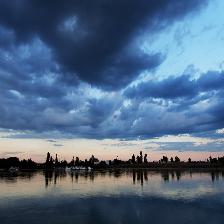

label:  tensor(0)


In [ ]:
######### sample visualization #########
i = 0

sample_img, sample_label = next(iter(trainloader))
sample_img = sample_img[i]


img = sample_img.detach().cpu().numpy() # tensor -> numpy
img = np.transpose(img, (1, 2, 0)) # [C,H,W] -> [H,W,C]
print(img[0][0])
img = image_inverse_transform(image=img)["image"]
print(img[0][0])
img = img * 255
print(img[0][0])
# img = img.astype(np.uint8).copy() # np.float32 -> np.uint8


cv2_imshow(img)
print('label: ', sample_label[i])

# Network

## ResNet101 implementation

In [ ]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()

        # implemented ResNet101
        self.conv1 = self.conv1_layer()
        self.conv2 = self.conv2_layer()
        self.conv3 = self.conv3_layer()
        self.conv4 = self.conv4_layer()
        self.conv5 = self.conv5_layer()
        self.FullyConnected = nn.Sequential(
            nn.Linear(2048, 50),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(50, 3)
        )

    def conv1_layer(self):
      return nn.Sequential(
          nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
          nn.BatchNorm2d(64),
          nn.ReLU(inplace=True)
      )

    def conv2_layer(self):
      layers = []
      layers.append(nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

      layers.append(conv_block(64, [64,64,256], 1))
      layers.append(identity_block([64,64,256]))
      layers.append(identity_block([64,64,256]))
      return nn.Sequential(*layers)

    def conv3_layer(self):
      layers = []
      layers.append(conv_block(256, [128,128,512], 2))
      for i in range(3):
        layers.append(identity_block([128,128,512]))
      return nn.Sequential(*layers)

    def conv4_layer(self):
      layers = []
      layers.append(conv_block(512, [256,256,1024], 2))
      for j in range(5):
        layers.append(identity_block([256,256,1024]))
      return nn.Sequential(*layers)

    def conv5_layer(self):
      layers = []
      layers.append(conv_block(1024, [512,512,2048], 2))
      for k in range(2):
        layers.append(identity_block([512,512,2048]))
      return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = F.adaptive_avg_pool2d(x, (1,1))
        x = x.view(x.size(0), -1)
        x = self.FullyConnected(x)
        return x

class conv_block(nn.Module):
  def __init__(self, in_channels, filters, strides):
    super(conv_block, self).__init__()
    self.filters1, self.filters2, self.filters3 = filters
    self.conv1 = nn.Conv2d(in_channels, self.filters1, kernel_size=1, stride=strides, padding=0, bias=False)
    self.bn1 = nn.BatchNorm2d(self.filters1)
    self.conv2 = nn.Conv2d(self.filters1, self.filters2, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(self.filters2)
    self.conv3 = nn.Conv2d(self.filters2, self.filters3, kernel_size=1, stride=1, padding=0, bias=False)
    self.bn3 = nn.BatchNorm2d(self.filters3)
    self.skip = nn.Sequential(
      nn.Conv2d(in_channels, self.filters3, kernel_size=1, stride=strides, bias=False),
      nn.BatchNorm2d(self.filters3)
    )
    self.fc1 = nn.Sequential(
        nn.Conv2d(self.filters3, self.filters3//16, kernel_size=1),
        nn.ReLU()
    )
    self.fc2 = nn.Sequential(
        nn.Conv2d(self.filters3//16, self.filters3, kernel_size=1),
        nn.Sigmoid()
    )

  def forward(self, x):
    out = self.conv1(x)
    out = self.bn1(out)
    out = F.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out = F.relu(out)

    out = self.conv3(out)
    out = self.bn3(out)

    w = F.avg_pool2d(out, kernel_size=out.size(2))
    w = self.fc1(w)
    w = self.fc2(w)
    out = out*w

    out += self.skip(x)
    out = F.relu(out)
    return out

class identity_block(nn.Module):
  def __init__(self, filters):
    super(identity_block, self).__init__()
    self.filters1, self.filters2, self.filters3 = filters
    self.conv1 = nn.Conv2d(self.filters3, self.filters1, kernel_size=1, stride=1, padding=0, bias=False)
    self.bn1 = nn.BatchNorm2d(self.filters1)
    self.conv2 = nn.Conv2d(self.filters1, self.filters2, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(self.filters2)
    self.conv3 = nn.Conv2d(self.filters2, self.filters3, kernel_size=1, stride=1, padding=0, bias=False)
    self.bn3 = nn.BatchNorm2d(self.filters3)

    self.fc1 = nn.Sequential(
        nn.Conv2d(self.filters3, self.filters3//16, kernel_size=1),
        nn.ReLU()
    )
    self.fc2 = nn.Sequential(
        nn.Conv2d(self.filters3//16, self.filters3, kernel_size=1),
        nn.Sigmoid()
    )

  def forward(self, x):
    out = self.conv1(x)
    out = self.bn1(out)
    out = F.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out = F.relu(out)

    out = self.conv3(out)
    out = self.bn3(out)

    w = F.avg_pool2d(out, kernel_size=out.size(2))
    w = self.fc1(w)
    w = self.fc2(w)
    out = out*w

    out += x
    out = F.relu(out)
    return out

####################################
print('Building Network!')
net = ResNet()

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

############ Parameters #############
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=5e-5, amsgrad=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
epochs = 30
#####################################

# sample_img, sample_label = next(iter(trainloader))
# output = net(sample_img)
# print(output, 'label: ', sample_label)

def train(epoch):
    print('\nTrain:')
    net.train()
    train_loss = 0
    for batch_idx, (images, targets) in enumerate(trainloader):
        optimizer.zero_grad()
        images, targets = images.to(device), targets.to(device)
        outputs = net(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        if ((batch_idx+1) % (len(trainloader)/3) == 1) or batch_idx+ 1 == len(trainloader):
            print('[%3d/%3d] | Loss: %.5f'%(batch_idx+1, len(trainloader), train_loss/(batch_idx+1)))
    # print('[%3d/%3d] | Loss: %.5f'%(batch_idx+1, len(trainloader), train_loss/(batch_idx+1)))

def val(epoch):
    print('\nValidation:')
    net.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(valloader):

            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)

            loss = criterion(outputs, labels)
            val_loss += loss.item()
            scheduler.step()

            if ((batch_idx+1) % (len(valloader)/3) == 1) or batch_idx+ 1 == len(valloader):
                print('[%3d/%3d] | Loss: %.5f'%(batch_idx+1, len(valloader), val_loss/(batch_idx+1)))
        # print('[%3d/%3d] | Loss: %.5f'%(batch_idx+1, len(valloader), val_loss/(batch_idx+1)))

for epoch in range(epochs):
    print('\nEpoch %d'%(epoch))
    train(epoch)
    val(epoch)

Building Network!

Epoch 0

Train:
[  1/267] | Loss: 1.30073
[ 90/267] | Loss: 0.74296
[179/267] | Loss: 0.65836
[267/267] | Loss: 0.60195

Validation:
[  1/ 34] | Loss: 0.12860
[ 34/ 34] | Loss: 0.39834

Epoch 1

Train:
[  1/267] | Loss: 0.44628
[ 90/267] | Loss: 0.46102
[179/267] | Loss: 0.44936
[267/267] | Loss: 0.44047

Validation:
[  1/ 34] | Loss: 0.21969
[ 34/ 34] | Loss: 0.33976

Epoch 2

Train:
[  1/267] | Loss: 0.42173
[ 90/267] | Loss: 0.40003
[179/267] | Loss: 0.42344
[267/267] | Loss: 0.41441

Validation:
[  1/ 34] | Loss: 0.23356
[ 34/ 34] | Loss: 0.33740

Epoch 3

Train:
[  1/267] | Loss: 0.10491
[ 90/267] | Loss: 0.40301
[179/267] | Loss: 0.41352
[267/267] | Loss: 0.41104

Validation:
[  1/ 34] | Loss: 0.23059
[ 34/ 34] | Loss: 0.32836

Epoch 4

Train:
[  1/267] | Loss: 0.37285
[ 90/267] | Loss: 0.43775
[179/267] | Loss: 0.39975
[267/267] | Loss: 0.39851

Validation:
[  1/ 34] | Loss: 0.21993
[ 34/ 34] | Loss: 0.32628

Epoch 5

Train:
[  1/267] | Loss: 0.26905
[ 90/267]

In [ ]:
test_loss = 0


with torch.no_grad():
    print('\nTest:')
    net.eval()
    for batch_idx, (images, labels) in enumerate(testloader):
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        if batch_idx+1 == len(testloader):
            print('[%3d/%3d] | final_Loss: %f'%(batch_idx+1, len(testloader), test_loss/(batch_idx+1)))


Test:


KeyboardInterrupt: ignored

## Pretrained ResNet101

In [ ]:
########### Load pretrained model ################

net = torchvision.models.resnet101(pretrained = True)

# set fully connected layer
net.fc = nn.Sequential(
            nn.Linear(2048, 50),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(50, 3)
    )

print('Building Network!')
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

############ Parameters #############
criterion = nn.CrossEntropyLoss() # 자체적으로 log_softmax, one hot encoding 수행
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=5e-5, amsgrad=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
epochs = 30

############## Train #################

def train(epoch):
    print('\nTrain:')
    net.train()
    train_loss = 0
    for batch_idx, (images, targets) in enumerate(trainloader):
        optimizer.zero_grad()
        images, targets = images.to(device), targets.to(device)
        outputs = net(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        if ((batch_idx+1) % (len(trainloader)/3) == 1) or batch_idx+ 1 == len(trainloader):
            print('[%3d/%3d] | Loss: %.5f'%(batch_idx+1, len(trainloader), train_loss/(batch_idx+1)))

def val(epoch):
    print('\nValidation:')
    net.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(valloader):

            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)

            loss = criterion(outputs, labels)
            val_loss += loss.item()
            scheduler.step()

            if ((batch_idx+1) % (len(valloader)/3) == 1) or batch_idx+ 1 == len(valloader):
                print('[%3d/%3d] | Loss: %.5f'%(batch_idx+1, len(valloader), val_loss/(batch_idx+1)))

for epoch in range(epochs):
    print('\nEpoch %d'%(epoch))
    train(epoch)
    val(epoch)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:03<00:00, 45.3MB/s]


Building Network!

Epoch 0

Train:
[  1/267] | Loss: 1.14030
[ 90/267] | Loss: 0.57407
[179/267] | Loss: 0.51839
[267/267] | Loss: 0.48398

Validation:
[  1/ 34] | Loss: 0.11383
[ 34/ 34] | Loss: 0.27621

Epoch 1

Train:
[  1/267] | Loss: 0.17754
[ 90/267] | Loss: 0.28224
[179/267] | Loss: 0.26530
[267/267] | Loss: 0.26481

Validation:
[  1/ 34] | Loss: 0.13304
[ 34/ 34] | Loss: 0.19941

Epoch 2

Train:
[  1/267] | Loss: 0.06245
[ 90/267] | Loss: 0.24702
[179/267] | Loss: 0.23436
[267/267] | Loss: 0.23005

Validation:
[  1/ 34] | Loss: 0.07252
[ 34/ 34] | Loss: 0.19744

Epoch 3

Train:
[  1/267] | Loss: 0.07049
[ 90/267] | Loss: 0.20542
[179/267] | Loss: 0.20789
[267/267] | Loss: 0.21954

Validation:
[  1/ 34] | Loss: 0.05546
[ 34/ 34] | Loss: 0.19865

Epoch 4

Train:
[  1/267] | Loss: 0.03275
[ 90/267] | Loss: 0.20848
[179/267] | Loss: 0.21778
[267/267] | Loss: 0.23640

Validation:
[  1/ 34] | Loss: 0.09791
[ 34/ 34] | Loss: 0.19474

Epoch 5

Train:
[  1/267] | Loss: 0.22381
[ 90/267]

In [ ]:
test_loss = 0

correct = 0
total = 0

with torch.no_grad():
    print('\nTest:')
    net.eval()
    for batch_idx, (images, labels) in enumerate(testloader):
      optimizer.zero_grad()
      images, labels = images.to(device), labels.to(device)
      outputs = net(images)

      _, prediction = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (prediction==labels).sum().item()

      loss = criterion(outputs, labels)
      test_loss += loss.item()
      if batch_idx+1 == len(testloader):
          print('[%3d/%3d] | final_Loss: %f'%(batch_idx+1, len(testloader), test_loss/(batch_idx+1)))

          print(f"# Accuracy: {100*correct//total} %")



Test:
[135/135] | final_Loss: 0.160113
# Accuracy: 94 %


## Save Model parameters, Load

In [ ]:
######### Save Model ############
PATH = './pre_resnet101.pth'
torch.save(net.state_dict(), PATH)
#################################

[0.13333334 0.20392159 0.24705884]
[0.13333334 0.20392159 0.24705884]
[34.       52.000004 63.000004]


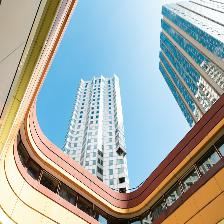

## truth:  tensor([0, 0], device='cuda:0')
## probability:  tensor([[9.9741e-01, 2.0520e-03, 5.3632e-04],
        [9.6553e-01, 6.0195e-03, 2.8450e-02]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
## prediction:  tensor([0, 0], device='cuda:0')
## loss:  tensor(0.0094, device='cuda:0', grad_fn=<DivBackward0>)


In [ ]:
sample_img, sample_label = next(iter(testloader))
sample_img, sample_label = sample_img.to(device), sample_label.to(device)

############# Load Model ##############
# net = net()
net.load_state_dict(torch.load(PATH))
output = net(sample_img)
#######################################

######### sample visualization #########
img = sample_img[0]
img = img.detach().cpu().numpy() # tensor -> numpy
img = np.transpose(img, (1, 2, 0)) # [C,H,W] -> [H,W,C]  # print(img.shape)
print(img[0][0])
img = image_inverse_transform(image=img)["image"]
print(img[0][0])
img = img * 255
print(img[0][0])
# img = img.astype(np.uint8).copy() # np.float32 -> np.uint8

cv2_imshow(img)

#######################################

print('## truth: ', sample_label)
print('## probability: ', F.softmax(output, 1)) # softmax -> 합이 1인 확률값
_, pred = torch.max(output, 1)
print('## prediction: ', pred)
print('## loss: ', criterion(output, sample_label)/2)

# 0: day 1: night 2: sunrise